In [ ]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

print(tf.version.VERSION)

2.12.0


In [ ]:
VOCAB_SIZE = 20000
ATTENTION_DIM = 512
WORD_EMBEDDING_DIM = 128

FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

Preparing the dataset:

In [ ]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000

def get_image_text(image1):
  caption = image1["captions"]["text"][0]
  img = image1["image"]
  img = tf.image.resize(img, (IMG_HEIGHT,IMG_WIDTH))
  img = img/255
  return {"image_tensor":img , "caption":caption}

trainds = tfds.load("coco_captions", split='train[0:8000]', data_dir=GCS_DIR)
trainds

trainds = trainds.map(
    get_image_text, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:

trainds

<_PrefetchDataset element_spec={'image_tensor': TensorSpec(shape=(299, 299, 3), dtype=tf.float32, name=None), 'caption': TensorSpec(shape=(), dtype=tf.string, name=None)}>

Visualizing the dataset:

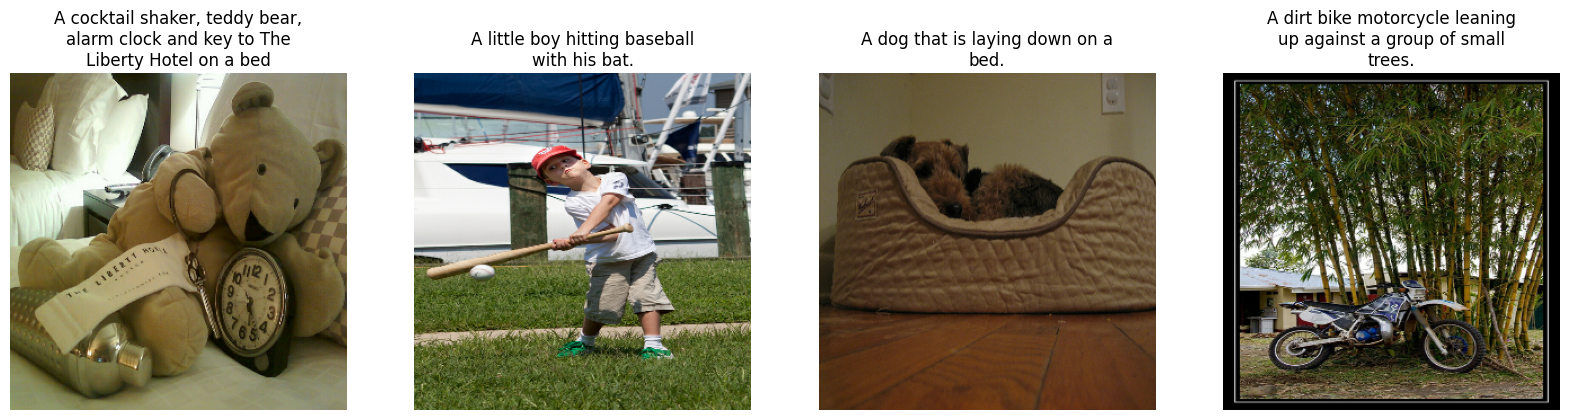

In [ ]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

Preprocessing the image captions:

In [ ]:
def add_sos_tokens(data):
  end = tf.convert_to_tensor("<end>")
  start = tf.convert_to_tensor("<start>")
  data["caption"] = tf.strings.join([start,data["caption"],end],separator = " ")
  return data

In [ ]:
trainds = trainds.map(add_sos_tokens)


In [ ]:
MAX_CAPTION_LEN = 64



def cleanup(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )



tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=cleanup,
    output_sequence_length=MAX_CAPTION_LEN,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))

In [ ]:
tokenizer(["<start> This is an example <end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  3, 168,  11,  18,   1,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [ ]:
example_captions = []
for d in trainds.take(5):
    example_captions.append(d["caption"].numpy())

In [ ]:
example_captions

[b'<start> A little girl holds on to a big and colorful kite. <end>',
 b"<start> The train with spray paint on it's side is passing a train crossing.  <end>",
 b'<start> A small airplane sitting on top of a tarmac. <end>',
 b'<start> A table topped with eaten utensils, plates and a centerpiece. <end>',
 b'<start> Man in the water with a sailboard and a large ship in background. <end>']

In [ ]:
for wordid in tokenizer([example_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")

<start> a little girl holds on to a big and colorful kite <end>                                                    

Word to Index and vice verse converter:

In [ ]:
#  Word -> Index
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

#  Index -> Word
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

Creating final dataset for training:

In [ ]:
BATCH_SIZE = 32

def create_ds(data):
  img = data["image_tensor"]
  caption = tokenizer(data["caption"])
  target = tf.roll(caption, -1, 0)
  zeros = tf.zeros([1], dtype=tf.int64)
  target = tf.concat((target[:-1], zeros), axis=-1)
  return (img, caption), target


batched_ds = (
    trainds.map(create_ds)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
batched_ds

<_PrefetchDataset element_spec=((TensorSpec(shape=(32, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, None), dtype=tf.int64, name=None)), TensorSpec(shape=(32, None), dtype=tf.int64, name=None))>

Model:


Image Encoder:

Makes use of the convolution layers of InceptionResNetV2 to extract features of the image


In [ ]:
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape = (IMG_HEIGHT , IMG_WIDTH , IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)
x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)


In [ ]:
encoder = tf.keras.Model(inputs = image_input , outputs = encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 reshape (Reshape)           (None, 64, 1536)          0         
                                                                 
 dense (Dense)               (None, 64, 512)           786944    
                                                                 
Total params: 55,123,680
Trainable params: 786,944
Non-trainable params: 54,336,736
_________________________________________________________________


Caption Decoder:

makes use of hard attention and grus in order to assign captions to images

In [ ]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)

gru_output , gru_state =decoder_gru(embed)

decoder_attention = Attention()
context_vector = decoder_attention([gru_output , encoder_output])
addition = Add()([gru_output, context_vector])

normit = LayerNormalization(axis=-1)
normout = normit(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(normout)



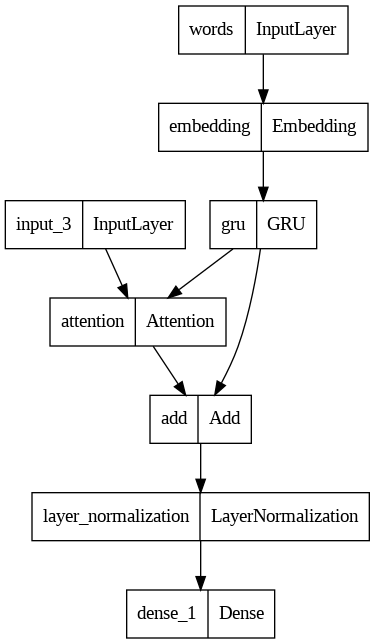

In [ ]:
decoder = tf.keras.Model(
    inputs=[word_input, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)

In [ ]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words (InputLayer)             [(None, 64)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 64, 512)      10240000    ['words[0][0]']                  
                                                                                                  
 gru (GRU)                      [(None, 64, 512),    1575936     ['embedding[1][0]']              
                                 (None, 512)]                                                     
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 512)]    0           []                         

Training Phase:

In [ ]:
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

In [ ]:
%%time
history = image_caption_train_model.fit(batched_ds, epochs=1)

375/375 [==============================] - 8251s 22s/step - loss: 0.9050
CPU times: user 3h 47min 26s, sys: 10min 3s, total: 3h 57min 29s
Wall time: 2h 17min 30s


Get the Caption:

In [ ]:
gru_state_input = Input(shape = (ATTENTION_DIM) , name = "gru_state_input")

gru_output , gru_state = decoder_gru(embed , initial_state = gru_state_input)

context_vector = decoder_attention([gru_output , encoder_output])
addition_output = Add()([gru_output,context_vector])
normout = normit(addition_output)
decoder_output = decoder_output_dense(normout)

decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state],
)

In [ ]:
MINIMUM_SENTENCE_LENGTH = 7


## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

    img = tf.image.decode_png(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )


        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word_to_index("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

In [ ]:
filename = "/content/a4e1c55a9.png"

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

In [ ]:
import os
import sys
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch



sys.path.append('D:/IMAGE TO PROMPT PROJECT/sentence-transformers-XYZ/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

comp_path = Path('D:/IMAGE TO PROMPT PROJECT/stable diffusion - image to prompts/')

In [ ]:
!pip install sentence_transformers

In [ ]:
df_submission = pd.read_csv( 'sample_submission.csv', index_col='imgId_eId')
df_submission.head()

In [ ]:
prompts_df = pd.read_csv("prompts.csv")
prompts_df